In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import nibabel as nib
import numpy as np
from tqdm import tqdm
from torchvision.transforms import Compose

In [3]:
# Custom dataset class for handling NIfTI files
class BrainDataset(Dataset):
    def __init__(self, t1w_files, t2w_files, fa_files, adc_files, transform=None):
        self.t1w_files = t1w_files
        self.t2w_files = t2w_files
        self.fa_files = fa_files
        # self.adc_files = adc_files
        self.transform = transform

    def __len__(self):
        return len(self.t1w_files)

    def __getitem__(self, idx):
        t1w_image = nib.load(self.t1w_files[idx]).get_fdata()
        t2w_image = nib.load(self.t2w_files[idx]).get_fdata()
        fa_image = nib.load(self.fa_files[idx]).get_fdata()
        # adc_image = nib.load(self.adc_files[idx]).get_fdata()

        # input_image = np.stack([t1w_image, t2w_image], axis=0)
        t1w_image = np.stack([t1w_image], axis=0)
        # target_image = np.stack([fa_image, adc_image], axis=0)
        t2w_image = np.stack([t2w_image], axis=0)
        fa_image = np.stack([fa_image], axis=0)

        # if self.transform:
            # input_image = self.transform(input_image)
            # target_image = self.transform(target_image)

        # return input_image, target_image
        return t1w_image, t2w_image, fa_image

In [4]:
import os
from torch.utils.data import DataLoader

os.chdir('../data/output14')

t1w_files = []
t2w_files = []
fa_files = []
adc_files = []

# Loop for patient folders from 000 to 069
for patient_id in range(1,3):
    patient_folder = str(patient_id).zfill(3)
    registered_path = os.path.join(patient_folder, "registered")
    registered2_path = os.path.join(patient_folder, "registered2")
    normalized_path = os.path.join(patient_folder, "normalized")

    try:
        t1w_files.append(os.path.join(normalized_path, "T1w_1mm_normalized.nii.gz"))
        t2w_files.append(os.path.join(registered_path, "T2w_registered.nii.gz"))
        adc_files.append(os.path.join(registered2_path, "ADC_registered.nii.gz"))
        fa_files.append(os.path.join(registered2_path, "FA_registered.nii.gz"))
    except FileNotFoundError:
        print(f"File not found for patient folder: {patient_folder}")

"""
# Loop for patient folders from 111 to 200
for patient_id in range(111, 201):
    if patient_id == 163:
        continue  # Skip patient folder 163
    patient_folder = str(patient_id)
    registered_path = os.path.join(patient_folder, "registered")
    registered2_path = os.path.join(patient_folder, "registered2")
    normalized_path = os.path.join(patient_folder, "normalized")

    try:
        t1w_files.append(os.path.join(normalized_path, "T1w_1mm_normalized.nii.gz"))
        t2w_files.append(os.path.join(registered_path, "T2w_registered.nii.gz"))
        adc_files.append(os.path.join(registered2_path, "ADC_registered.nii.gz"))
        fa_files.append(os.path.join(registered2_path, "FA_registered.nii.gz"))
    except FileNotFoundError:
        print(f"File not found for patient folder: {patient_folder}")
        """

dataset = BrainDataset(
    t1w_files, t2w_files, fa_files, adc_files, transform=Compose([torch.tensor])
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 0 for FA, 1 for ADC
output_modality = 0

# Print t1w files on separate lines
for t1w_file in t1w_files:
    print(t1w_file)

print("Total number of samples:", len(dataset))


001/normalized/T1w_1mm_normalized.nii.gz
002/normalized/T1w_1mm_normalized.nii.gz
Total number of samples: 2


In [5]:
# for inputs, targets in tqdm(dataloader):
#     inputs, targets = inputs.to(device), targets.to(device)

#     print(inputs.shape)
#     print(targets.shape)

for t1, t2, fa in tqdm(dataloader):
    t1, t2, fa = t1.to(device), t2.to(device), fa.to(device)

    print(t1.shape)
    print(t2.shape)

100%|██████████| 1/1 [00:04<00:00,  4.23s/it]

torch.Size([2, 1, 182, 218, 182])
torch.Size([2, 1, 182, 218, 182])


In [6]:
input_shape = (1, 182, 218, 182)

nc = 1 # num channels

ngf = 32 # size of feature maps in generator

ndf = 32 # size of feature maps in discriminator

num_epochs = 5 # 200

lr = 0.0002

betas = (0.5, 0.999) # beta1 hyperparameter for Adam optimizers

ngpu = 1 # number of GPUs available, 0 for CPU mode

batch_size = 128 # batch size during training

latent_dim = 256

ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            # input is 1 x 182 x 218 x 182
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer2 = nn.Sequential(
            # input is 32 x 91 x 109 x 91
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer3 = nn.Sequential(
            # input is 64 x 45 x 54 x 45
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer4 = nn.Sequential(
            # input is 128 x 22 x 27 x 22
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            nn.LeakyReLU(0.2, inplace=True),
            # output is 128 x 11 x 13 x 11
        )

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x1, x2, x3, x4
"""
# Initialize the model and move it to GPU if available
model = ConvNet().to(device)

# You might need to adjust the size of your input tensor
# and make sure you have a batch dimension (first dimension)
input_tensor = torch.randn((2, 1, 182, 218, 182)).to(device)

output = model(input_tensor)
print("Output shape: ", output.shape)
"""


'\n# Initialize the model and move it to GPU if available\nmodel = ConvNet().to(device)\n\n# You might need to adjust the size of your input tensor\n# and make sure you have a batch dimension (first dimension)\ninput_tensor = torch.randn((2, 1, 182, 218, 182)).to(device)\n\noutput = model(input_tensor)\nprint("Output shape: ", output.shape)\n'

In [22]:
t1_model = ConvNet().to(device)
t2_model = ConvNet().to(device)

In [27]:
# Define the input shape
img_shape = (2, 182, 218, 182)

# Define the generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # self.fc_layer = nn.Sequential(
        #     nn.Linear(latent_dim * 2, 128 * 22 * 27 * 22),
        #     nn.LeakyReLU(0.2),
        #     nn.BatchNorm1d(128 * 22 * 27 * 22)
        # )
        self.layer1 = nn.Sequential(
            nn.Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2),
            nn.Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),            
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose3d(128 + 128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose3d(64 + 64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2),
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose3d(32 + 32, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.Tanh()
        )

    # x4 is concatenated between 2 images
    # x1, x2, and x3 are averaged between 2 images
    def forward(self, x1, x2, x3, x4):
        x = self.layer1(x4)
        print(x.shape)
        x = self.layer2(torch.cat([x, x3]), dim=1)
        print(x.shape)
        x = self.layer3(torch.cat([x, x2]), dim=1)
        print(x.shape)
        x = self.layer4(torch.cat([x, x1]), dim=1)
        print(x.shape)
        return x

SyntaxError: invalid syntax (<ipython-input-27-60973c3fb00a>, line 17)

In [17]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.Dropout3d(0.25),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            #nn.Dropout3d(0.25),
            nn.Flatten(),
            # nn.Linear(64 * 23* 28 * 23, 128),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(128, 64),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(64, 1),
            # nn.Linear(64 * 36 * 43 * 36, 1),
            nn.Linear(7448320, 1), # 64 x 45 x 54 x 45
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

In [24]:
# Create the discriminator and generator models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# generator.apply(weights_init)
# discriminator.apply(weights_init)

# Define the loss function and optimizer for the discriminator and generator
adversarial_loss = nn.BCELoss()
al_w = 1
# generative_loss = nn.MSELoss()
pixelwise_loss = nn.L1Loss()
pl_w = 0.1
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_T1 = torch.optim.Adam(t1_model.parameters(), lr=lr*10, betas=betas)
optimizer_T2 = torch.optim.Adam(t2_model.parameters(), lr=lr*10, betas=betas)

In [26]:

from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint

## Change to True / False if you do / do not want 
## to load the previously saved state dictionaries
load = False
if load:
    generator.load_state_dict(torch.load("generator.pt"))
    discriminator.load_state_dict(torch.load("discriminator.pt"))
    t1_model.load_state_dict(torch.load("t1_model.pt"))
    t2_model.load_state_dict(torch.load("t2_model.pt"))

img_list = []
G_losses = []
D_losses = []
iters = 0

torch.cuda.empty_cache()

batch_size = 2
img_shape = (batch_size, 182, 218, 182)

# Train the models
for epoch in range(num_epochs):
    i = 0
    for t1, t2, fa in tqdm(dataloader):
        t1, t2, fa = t1.to(device), t2.to(device), fa.to(device)
        
        # update D: maximize log(D(x)) + log(1 - D(G(z)))
        # train with all-real batch
        discriminator.zero_grad()
        real_images = fa.float()
        real_labels = torch.ones(real_images.shape[0], 1).cuda()
        real_predictions = discriminator(real_images)
        real_loss = adversarial_loss(real_predictions, real_labels)
        real_loss.backward()

        # create latent space and update D with fake image
        # t1_latent = t1_model(t1.float()) 
        t1x1, t1x2, t1x3, t1x4 = t1_model(t1.float()) 
        # t2_latent = t2_model(t2.float())
        t2x1, t2x2, t2x3, t2x4 = t2_model(t2.float())
        # latent = t1_latent + t2_latent
        # latent = torch.concat((t1_latent.detach(), t2_latent.detach()), 1)
        x4 = torch.concat((t1x4.detach(), t2x4.detach()), 1)
        print(x4.shape)
        x3 = t1x3.detach() + t2x3.detach()
        x2 = t1x2.detach() + t2x2.detach()
        x1 = t1x1.detach() + t2x1.detach()
        fake_images = generator(x1, x2, x3, x4)
        fake_images = torch.nn.functional.pad(fake_images, pad=(3, 3, 5, 5, 3, 3), mode='replicate') # kinda sketch 
        fake_labels = torch.zeros(fake_images.shape[0], 1).cuda()
        fake_predictions = discriminator(fake_images.detach())
        fake_loss = adversarial_loss(fake_predictions, fake_labels)
        fake_loss.backward()

        discriminator_loss = real_loss + fake_loss
        optimizer_D.step()

        # update G network: maximize log(D(G(z)))
        generator.zero_grad()
        t1_model.zero_grad()
        t2_model.zero_grad()

        fake_images = generator(x1, x2, x3, x4)
        fake_images = torch.nn.functional.pad(fake_images, pad=(3, 3, 1, 1, 3, 3), mode='replicate') # kinda sketch 
        fake_predictions = discriminator(fake_images)
        errG = adversarial_loss(fake_predictions, real_labels)
        errR = pixelwise_loss(fake_images, fa.float())
        generator_loss = al_w*errG + pl_w*errR
        generator_loss.backward()
        optimizer_G.step()     
        optimizer_T1.step()
        optimizer_T2.step()   

        # output training stats
        #if i % 50 == 0:
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())

        # Print the losses
        if i % 100 == 0:
            print("Epoch [%d/%d], Step [%d/%d], Discriminator Loss: %.4f, Generator Loss: %.4f"
                  % (epoch, num_epochs, i, len(dataloader), discriminator_loss.item(), generator_loss.item()))
            torch.save(generator.state_dict(), "generator.pt")
            torch.save(discriminator.state_dict(), "discriminator.pt")
            torch.save(t1_model.state_dict(), "t1_model.pt")
            torch.save(t2_model.state_dict(), "t2_model.pt")

            torch.cuda.empty_cache()
            
        i += 1
            
        iters += 1

        # t1_latent = t1_model(t1) 


  0%|          | 0/1 [00:02<?, ?it/s]

torch.Size([2, 512, 11, 13, 11])
torch.Size([2, 128, 11, 13, 11])


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 11 but got size 22 for tensor number 1 in the list.

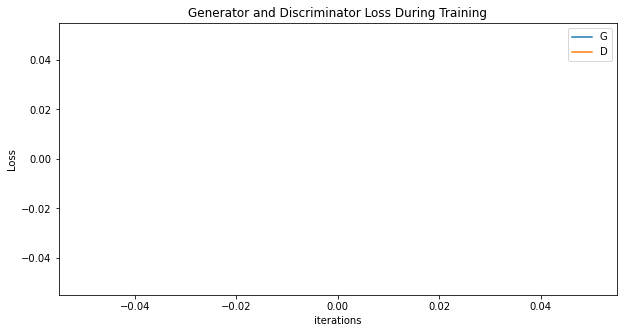

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

/home/ubuntu/final/data/output14
torch.Size([1, 1, 182, 218, 182])


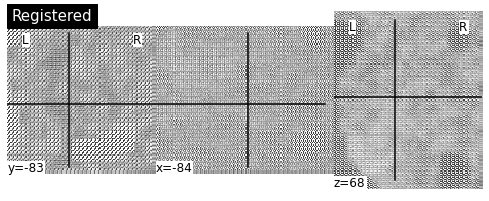

Image dimensions: (145, 174, 145)


In [ ]:
import os
import torch
import numpy as np
import SimpleITK as sitk
from nilearn import plotting
import matplotlib
import matplotlib.pyplot as plt
!pwd

os.chdir('../output14')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
t1_model = ConvNet().to(device)
t2_model = ConvNet().to(device)

# Load the trained weights
generator.load_state_dict(torch.load("generator.pt"))
discriminator.load_state_dict(torch.load("discriminator.pt"))
t1_model.load_state_dict(torch.load("t1_model.pt"))
t2_model.load_state_dict(torch.load("t2_model.pt"))

generator.eval()
discriminator.eval()
t1_model.eval()
t2_model.eval()

def generate_img(t1w_path, t2w_path):
    # Load the images as SimpleITK images
    t1w_image_sitk = sitk.ReadImage(t1w_path)
    t2w_image_sitk = sitk.ReadImage(t2w_path)

    # Convert the images to numpy arrays
    t1w_image = sitk.GetArrayFromImage(t1w_image_sitk)
    t2w_image = sitk.GetArrayFromImage(t2w_image_sitk)

    # Convert the images to torch tensors and add a batch dimension
    t1w_image = np.stack([t1w_image])
    t1w_image = torch.from_numpy(t1w_image).unsqueeze(0).float().to(device)
    t2w_image = np.stack([t2w_image])
    t2w_image = torch.from_numpy(t2w_image).unsqueeze(0).float().to(device)
    print((t1w_image).shape)

    # Pass the images through the models
    t1_latent = t1_model(t1w_image)
    t2_latent = t2_model(t2w_image)
    latent = torch.cat((t1_latent, t2_latent), 1)
    generated_image = generator(latent)
    generated_image = torch.nn.functional.pad(generated_image, pad=(3, 3, 1, 1, 3, 3), mode='replicate')

    # Convert the tensor back to numpy
    generated_image = generated_image.squeeze().cpu().detach().numpy()

    # Create a SimpleITK image from the numpy array
    sitk_image = sitk.GetImageFromArray(generated_image)

    # Resample the image
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize((145, 174, 145))
    resampler.SetInterpolator(sitk.sitkLinear)
    resampled_image = resampler.Execute(sitk_image)

    # Convert the resampled image back to a numpy array
    resampled_array = sitk.GetArrayFromImage(resampled_image)

    return resampled_array

# Call the function with the paths to your T1W and T2W images
synthesized_fa_image = generate_img('../output8/E11/normalized/T1w_1mm_normalized.nii.gz', '../output8/E11/registered/T2w_align.nii.gz')

# Save the synthesized image to a file
sitk.WriteImage(sitk.GetImageFromArray(synthesized_fa_image), 'synthesized_fa_image.nii.gz')

def display_image(input_image_file, title):
    """
    Display NIfTI image using nilearn.
    
    Args:
        input_image_file (str): Path to the original NIfTI file.
        output_image_file (str): Path to the skull-stripped NIfTI file.
        title (str): Title of the plot.
    """
    plotting.plot_anat(input_image_file, title=title, display_mode='ortho')
    plotting.show()

display_image('synthesized_fa_image.nii.gz','Registered')

import nibabel as nib

# Load the NIfTI image
image_path = 'synthesized_fa_image.nii.gz'
image = nib.load(image_path)

# Get the image dimensions
image_shape = image.shape

print("Image dimensions:", image_shape)




In [ ]:
# Change the working directory to the "data" folder
!pwd
os.chdir('../output8')

# Get the list of patient folders
patient_folders = [folder for folder in os.listdir() if os.path.isdir(folder)]

# Register images to T1w space using Diffeomorphic Demons
for patient_folder in patient_folders:
    output_folder = os.path.abspath(patient_folder)

    # Create the output folder for the registered images
    synthesized_output_folder = os.path.join(output_folder, "synthesized")
    os.makedirs(synthesized_output_folder, exist_ok=True)

    t1w_image_path = os.path.join(output_folder, "normalized", "T1w_1mm_normalized.nii.gz")
    t2w_image_path = os.path.join(output_folder, "registered", "T2w_align.nii.gz")
    #fa_image_path = os.path.join(output_folder, "registered", "FA_1.25mm_normalized.nii.gz")
    #adc_image_path = os.path.join(output_folder, "registered", "ADC_1.25mm_normalized.nii.gz")

    # synthesized_image_path = os.path.join(synthesized_output_folder, "ADC_synthesized.nii.gz")
    synthesized_image_path = os.path.join(synthesized_output_folder, "FA_synthesized.nii.gz")

    t1w_image_file = nib.load(t1w_image_path)
    t1w_image = t1w_image_file.get_fdata()
    t2w_image_file = nib.load(t2w_image_path)
    t2w_image = t2w_image_file.get_fdata()

    generated_image = generate_img(t1w_image, t2w_image)

    # visualize output vs actual file
    plt.rcParams["figure.figsize"]=20,20
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(generated_image[:,:,100])
    plt.title('Generated Image')
    plt.subplot(1,4,2)
    plt.title('Actual Image')
    plt.subplot(1,4,3)
    plt.imshow(generated_image[105,:,:])
    plt.title('Generated Image')
    plt.subplot(1,4,4)
    plt.title('Actual Image')
    plt.show()

    sitk.WriteImage(generated_image, synthesized_image_path)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])